In [1]:
import os
import openai  # !pip install openai==0.27.9
from dotenv import load_dotenv
load_dotenv()

True

# Upload files for fine-tuning job

In [2]:


os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

train_res = openai.files.create(
    file=open(os.path.join('data', "QA_pairs_train.jsonl"), 'rb'),
    purpose='fine-tune'
)
train_file_id = train_res.id
train_file_id


'file-b32axKrM5FsD5sEs03Iy47yX'

In [33]:
val_res = openai.files.create(
    file=open(os.path.join('data', "QA_pairs_val.jsonl"), 'rb'),
    purpose='fine-tune'
)
val_file_id = val_res.id
val_file_id

'file-Au2xxfjvgqzdtfAja4z51HJA'

In [50]:
train_file_id, val_file_id

('file-cpSbrvlbUVLgW5Tm4hDkbPzR', 'file-Au2xxfjvgqzdtfAja4z51HJA')

# Create fine-tuning job

In [125]:
finetune_job = openai.fine_tuning.jobs.create(
    training_file=train_file_id,
    validation_file=val_file_id,
    model="gpt-3.5-turbo-1106",
    hyperparameters={'n_epochs': 4, 'batch_size': 3}
)
ft_id = finetune_job.id
finetune_job

FineTuningJob(id='ftjob-VwAM3OQjjrOLtXlS1PLBAFA7', created_at=1704381836, error=None, fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=4, batch_size=3, learning_rate_multiplier='auto'), model='gpt-3.5-turbo-1106', object='fine_tuning.job', organization_id='org-G0vV5e5D0CmwKAucrz5lftdN', result_files=[], status='validating_files', trained_tokens=None, training_file='file-cpSbrvlbUVLgW5Tm4hDkbPzR', validation_file='file-Au2xxfjvgqzdtfAja4z51HJA')

# Check fine-tuning job status

In [137]:
# from wandb.integration.openai.fine_tuning import WandbLogger

# WANDB_PROJECT = "generative_agent"

# WandbLogger.sync(fine_tune_job_id=ft_id, project=WANDB_PROJECT, openai_client=openai.OpenAI(api_key=''))

In [161]:
# run = wandb.init(
#     project=WANDB_PROJECT,
#     job_type='eval'
# )

# VALIDATION_FILE_ARTIFACT_URI = '<entity>/<project>/valid-file-*' # REPLACE THIS WITH YOUR OWN ARTIFACT URI

# artifact_valid = run.use_artifact(
#     VALIDATION_FILE_ARTIFACT_URI,
#     type='validation_files'
# )

In [130]:
import time

while True:
    ftr = openai.fine_tuning.jobs.retrieve(fine_tuning_job_id=ft_id)
    print(ftr.status)
    if ftr.finished_at:
        fine_tuned_model = ftr.fine_tuned_model
        break
    time.sleep(60)


succeeded


In [131]:
openai.fine_tuning.jobs.retrieve(fine_tuning_job_id=ft_id).finished_at

1704382220

In [132]:
result_files = ftr.result_files
result_files

['file-78m4EEnvCPPegQRuu6BwyyK2']

In [133]:
metrics = openai.files.content(file_id=result_files[0])

In [134]:
import pandas as pd
import io
from matplotlib import pyplot as plt

df_metrics = pd.read_csv(io.StringIO(metrics.content.decode('UTF-8')))

<Axes: >

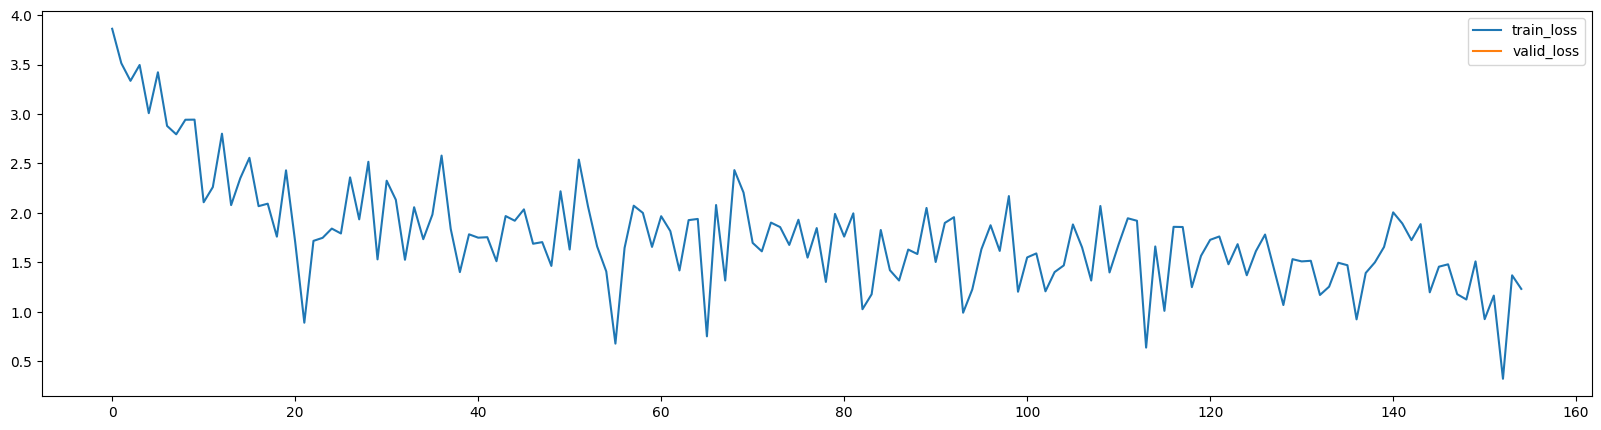

In [135]:
df_metrics.loc[:, ['train_loss', 'valid_loss']].plot(figsize=(20,5))

In [136]:
df_metrics

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,3.86088,0.50000,3.67802,0.43506
1,2,3.51265,0.47887,NaN,NaN
2,3,3.33509,0.47500,NaN,NaN
3,4,3.49519,0.53659,NaN,NaN
4,5,3.00833,0.55833,NaN,NaN
...,...,...,...,...,...
150,151,0.92765,0.76613,1.40485,0.57692
151,152,1.16572,0.69663,NaN,NaN
152,153,0.32539,0.90638,NaN,NaN
153,154,1.37040,0.63910,NaN,NaN


In [151]:
completions = openai.chat.completions.create(
        model=ftr.fine_tuned_model,
        messages=[
                {"role": "system", "content": "Assistant is a large language model trained by OpenAI.\n\nAssistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on topics related to provided documents.As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.\n\nAdditionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on the topics."}, 
                {"role": "user", "content": "How are generative agents instantiated in the paper's interactive sandbox environment?"}, 
                        #   {"role": "assistant", "content": "Large language models have been used to generate believable behavior by encoding a wide range of human behavior represented in their training data. They have been employed to generate users for social computing systems, replicate social science studies and political surveys, create interactive human behavior in gaming, and plan robotics tasks by decomposing action sequences."}
            ]
    )

In [152]:
completions.choices[0].message.content

'Generative agents are instantiated as part of the sandbox environment, allowing them to roam freely in the environment and interact with the user, other agents, and the environment itself.'

In [ ]:
'Generative agents are instantiated to populate an interactive sandbox environment inspired by The Sims, where end users can interact with a small town of twenty-five agents using natural language.'

In [159]:
completions = openai.chat.completions.create(
        model=ftr.fine_tuned_model,
        messages=[
                {"role": "system", "content": "Assistant is a large language model trained by OpenAI.\n\nAssistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on topics related to provided documents.As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.\n\nAdditionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on the topics."}, 
                {"role": "user", "content": "What can generative agents simulate?"}, 
                        #   {"role": "assistant", "content": "Large language models have been used to generate believable behavior by encoding a wide range of human behavior represented in their training data. They have been employed to generate users for social computing systems, replicate social science studies and political surveys, create interactive human behavior in gaming, and plan robotics tasks by decomposing action sequences."}
            ]
    )

In [160]:
completions.choices[0].message.content

'Generative agents can simulate the behavior of human characters in a realistic-looking three-dimensional environment.'